# Compare models to select the best hyperparameters
This tutorial will review **[AMPL](https://github.com/ATOMScience-org/AMPL)** functions for visualizing the results of a `hyperparameter search` in order to find the optimal hyperparameters for your model.

After performing a `hyperparameter search`, it is prudent to examine each hyperparameter in order to determine the best combination before training a production model with all of the data. Additionally, it is good to explore multiple performance metrics and visualize the predictions instead of relying solely on metrics.

For the purposes of this tutorial, we simply ran **tutorial 6, "Hyperparameter Optimization"** with different parameters such as those outlined **[here](https://github.com/ATOMScience-org/AMPL#hyperparameter-optimization)** to get enough models for comparison. Specifically, we created additional `NN` and `XGBoost` models as well as using `fingerprint` and `scaffold splits`. If you don't want to run that many models, you can use the result_df saved here: `dataset/SLC6A3_models/07_example_pred_df.csv`.

In this tutorial, we will focus on these functions:

* [plot_train_valid_test_scores](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.hyper_perf_plots.plot_train_valid_test_scores)
* [plot_split_perf](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.hyper_perf_plots.plot_split_perf)
* [plot_hyper_perf](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.hyper_perf_plots.plot_hyper_perf)
* [get_score_types](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.hyper_perf_plots.get_score_types)
* [plot_xg_perf](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.hyper_perf_plots.plot_xg_perf)
* [plot_pred_vs_actual_from_file](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.perf_plots.plot_pred_vs_actual_from_file)


## Import packages

In [1]:
from atomsci.ddm.pipeline import compare_models as cm
from atomsci.ddm.pipeline import hyper_perf_plots as hpp
from atomsci.ddm.pipeline import perf_plots as pp
import pandas as pd
pd.set_option('display.max_columns', None)

# ignore warnings in tutorials
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

Skipped loading some Jax models, missing a dependency. No module named 'haiku'
/opt/anaconda3/envs/atomsci-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get model results and filter
First we pull the results of the hyperparameter search into a dataframe. In **tutorial 6, "Hyperparameter Optimization"** we used `get_filesystem_perf_results()` which packs hyperparameters in a dict in the column `model_parameters_dict`. Here we use the individual hyperparameter columns to create visualizations.  

The `result_df` used here as an example is the result of calling `get_filesystem_perf_results()` once after training several hundred models with different parameters. These models were all saved in a single folder, but the function works iteratively so it can search an entire directory if a parent folder is passed.

In [2]:
# # call the function yourself
# result_df=cm.get_filesystem_perf_results(result_dir='dataset/SLC6A3_models/', pred_type='regression')

# use example results
result_df=pd.read_csv('dataset/SLC6A3_models/07_example_pred_df.csv', index_col=0)

result_df=result_df.sort_values('best_valid_r2_score', ascending=False)
print(result_df.shape)
result_df.head(2)

(467, 41)


,model_uuid,model_path,ampl_version,model_type,dataset_key,features,splitter,split_strategy,split_uuid,model_score_type,feature_transform_type,model_choice_score,best_train_r2_score,best_train_rms_score,best_train_mae_score,best_train_num_compounds,best_valid_r2_score,best_valid_rms_score,best_valid_mae_score,best_valid_num_compounds,best_test_r2_score,best_test_rms_score,best_test_mae_score,best_test_num_compounds,rf_estimators,rf_max_features,rf_max_depth,max_epochs,best_epoch,learning_rate,layer_sizes,dropouts,xgb_gamma,xgb_learning_rate,xgb_max_depth,xgb_colsample_bytree,xgb_subsample,xgb_n_estimators,xgb_min_child_weight,model_parameters_dict,feat_parameters_dict
310,b24a2887-8eca-43e2-8fc2-3642189d2c94,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,NN,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.562091,0.776865,0.585176,0.43255,1273,0.562091,0.799156,0.629897,273,0.519325,0.840682,0.649599,273,NaN,NaN,NaN,100.0,24.0,0.000083,"369,283,146","0.28,0.30,0.30",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""best_epoch"": 24, ""dropouts"": [0.278664215998...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}"
306,9b6c9332-15f3-4f96-9579-bf407d0b69a8,dataset/SLC6A3_models/SLC6A3_Ki_curated_model_...,1.6.0,RF,/home/apaulson/repos/AMPL_umbrella/AMPL/atomsc...,ecfp,scaffold,train_valid_test,c35aeaab-910c-4dcf-8f9f-04b55179aa1a,r2,normalization,0.559590,0.950677,0.275124,0.19340,1273,0.559590,0.801435,0.649692,273,0.480895,0.873642,0.693995,273,129.0,95.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""rf_estimators"": 129, ""rf_max_depth"": 32, ""rf...","{""ecfp_radius"": 2, ""ecfp_size"": 1024}"


We can look at a brief count of models for important parameters by creating a pivot table. Here we can see `ECFP` and `RDKit` features and `fingerprint` and `scaffold` splitters were used for each model type.

In [3]:
# model counts
model_counts=pd.DataFrame(result_df.groupby(['features','splitter','model_type'])['model_uuid'].count()).reset_index()
model_counts=model_counts.pivot(index='model_type',columns=['splitter','features',], values='model_uuid')
model_counts

splitter,fingerprint,scaffold,fingerprint,scaffold
features,ecfp,ecfp,rdkit_raw,rdkit_raw
model_type,,,,
NN,26,29,25,96
RF,30,30,30,32
xgboost,47,26,20,76


Often, certain random combinations of hyperparameters result in terribly performing models. Here we will filter those out so they don't affect the visualization by only keeping models with a validation `r2_score` of 0.1 or greater.

In [4]:
result_df.best_valid_r2_score.describe()

count    4.670000e+02
mean    -6.111789e+73
std      1.320769e+75
min     -2.854206e+76
25%     -2.751967e-01
50%      2.719028e-01
75%      4.323609e-01
max      5.620908e-01
Name: best_valid_r2_score, dtype: float64

In [5]:
# filter out objectively bad performing models
result_df=result_df[result_df.best_valid_r2_score>0.1]
result_df.shape

(264, 41)

In [6]:
result_df.best_valid_r2_score.describe()

count    264.000000
mean       0.405931
std        0.108515
min        0.110739
25%        0.337459
50%        0.418931
75%        0.484987
max        0.562091
Name: best_valid_r2_score, dtype: float64

After filtering out models with extremely poor metrics, we can see that some combinations don't work at all, and are completely filtered from the set. For example, decision tree based models using **[RDKit](https://github.com/rdkit/rdkit)** or **[ECFP](https://pubs.acs.org/doi/10.1021/ci100050t)** features work very poorly to predict on fingerprint-split models.

In [7]:
#  model counts
model_counts=pd.DataFrame(result_df.groupby(['features','splitter','model_type'])['model_uuid'].count()).reset_index()
model_counts=model_counts.pivot(index='model_type',columns=['splitter','features',], values='model_uuid')
model_counts

splitter,fingerprint,scaffold,fingerprint,scaffold
features,ecfp,ecfp,rdkit_raw,rdkit_raw
model_type,,,,
NN,8.0,23.0,11.0,86.0
RF,NaN,30.0,NaN,32.0
xgboost,3.0,21.0,NaN,50.0


## Visualize hyperparameters
There are several plotting functions in the `hyper_perf_plots` module that help visualize the different combinations of features for each type of model.

#### Examine overall scores
`plot_train_valid_test_scores()` gives a quick snapshot of your overall model performance. You can see if you overfitted and get a sense of whether your partitions are a good representation of future performance. Because the splitter can have a drastic effect on model performance, these plots are also separated by split type.

Here we see a fairly typical pattern where the training set metrics are higher than validation and test partitions. It is good to see that the validation and test scores are similar across many models, indicating that the models are not overfitting to the validation data. For fingerprint splits, we see a more worrying trend where the validation and test set metrics are not as consistent, suggesting that the split is not helping the model to generalize.

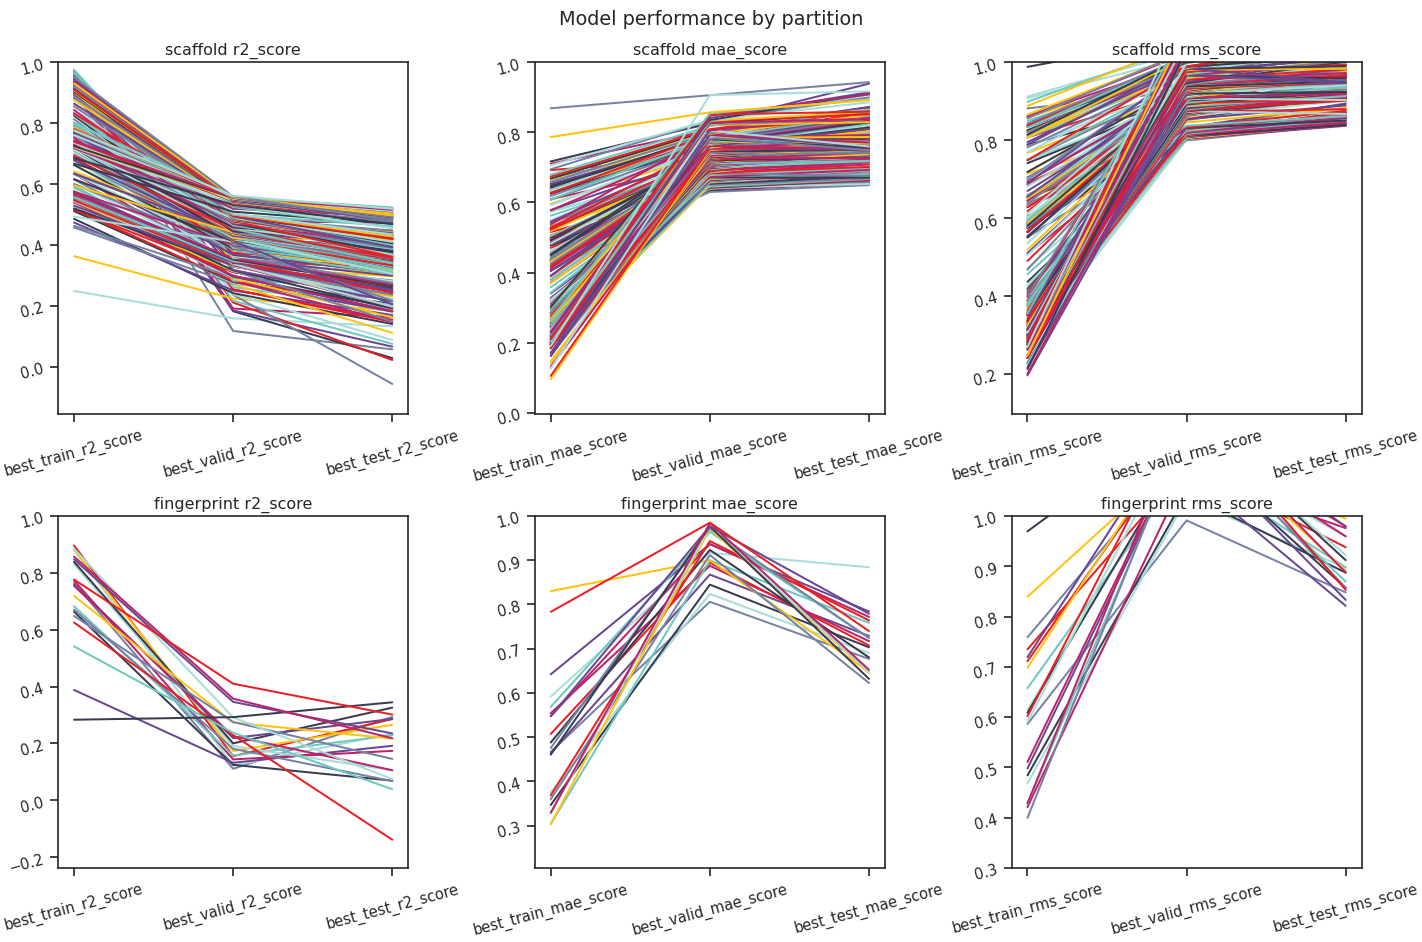

In [8]:
hpp.plot_train_valid_test_scores(result_df, prediction_type='regression')

#### Examine splits

`plot_split_perf()` plots the performance of each split type, separated by feature type, for each performance metric. 

We can see that `fingerprint splits` perform much worse than `scaffold splits` for this dataset, and but **[RDKit](https://github.com/rdkit/rdkit)** and **[ECFP](https://pubs.acs.org/doi/10.1021/ci100050t)** features perform differently. **[ECFP](https://pubs.acs.org/doi/10.1021/ci100050t)** features work better for `scaffold splits` while **[RDKit](https://github.com/rdkit/rdkit)** features work better for fingerprint splits. Recalling the filtering from above, we know that **[RDKit](https://github.com/rdkit/rdkit)** features for fingerprint splits are only represented by `NN` models.

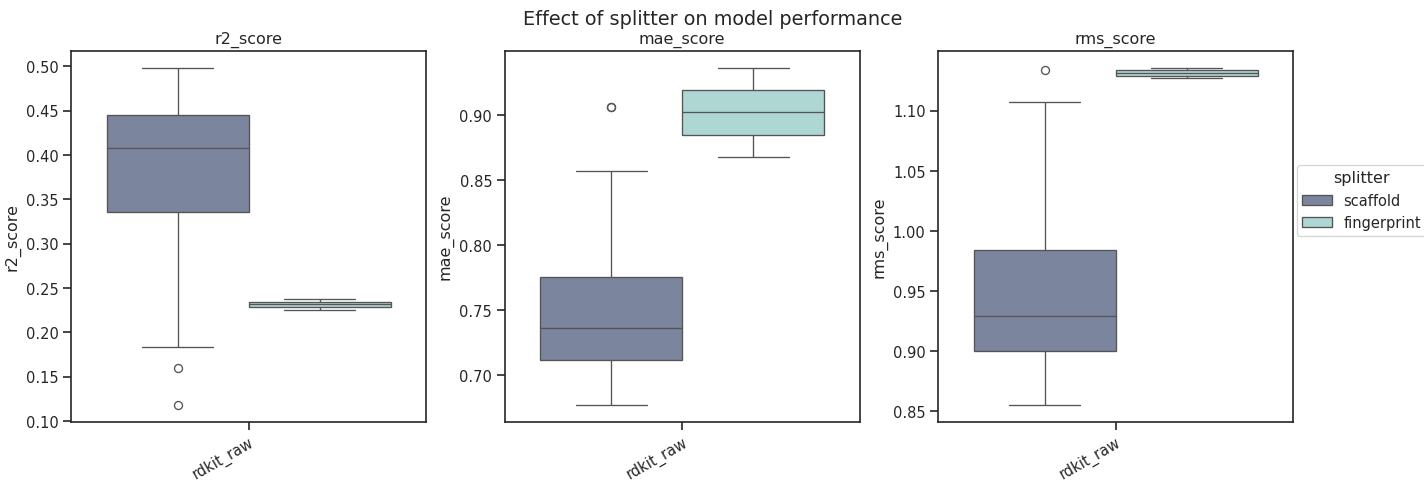

In [9]:
hpp.plot_split_perf(result_df, subset='valid')

#### General model features
We also want to understand general hyperparameters like model type and feature type and their effect on performance. We can use `plot_hyper_perf()` with `model_type='general'` as a shortcut to visualize these. 

We can see that `random forests` or neural networks perform the best while **[ECFP](https://pubs.acs.org/doi/10.1021/ci100050t)** features perform better than **[ECFP](https://pubs.acs.org/doi/10.1021/ci100050t)**. Additionally, the `random forest` models are very consistent while there is a lot of variability in the `NN` model performance.

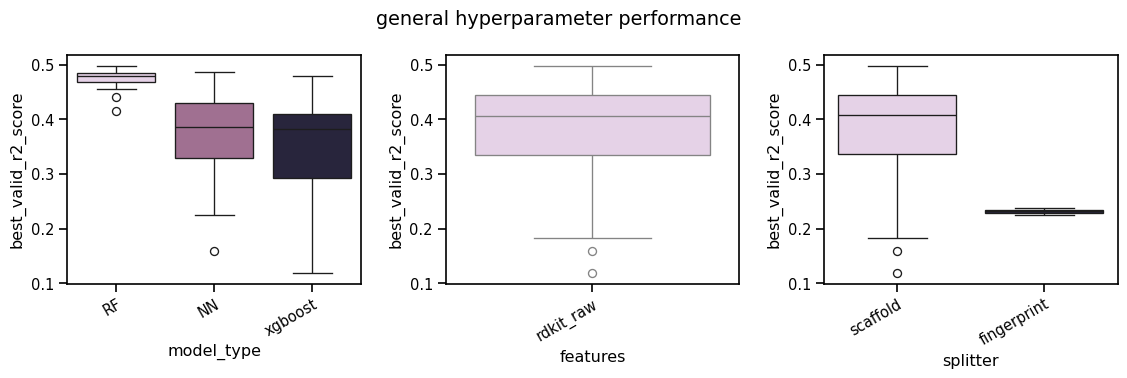

In [10]:
hpp.plot_hyper_perf(result_df)

#### RF-specific hyperparameters
We can also use `plot_hyper_perf()` to visualize model-specific hyperparameters. In this case we examine random forest models because they generally perform the best for this dataset.

Here, we can see two distinct sets of `valid_r2_scores` (probably from fingerprint vs scaffold split models), but both sets show similar trends. For `rf_estimators` it looks like 100-150 trees is optimal, while `rf_max_depth` does worse below ~15 and improves slowly after that. `rf_max_features` doesn't show a clear trend except that below 50 might result in worse models.

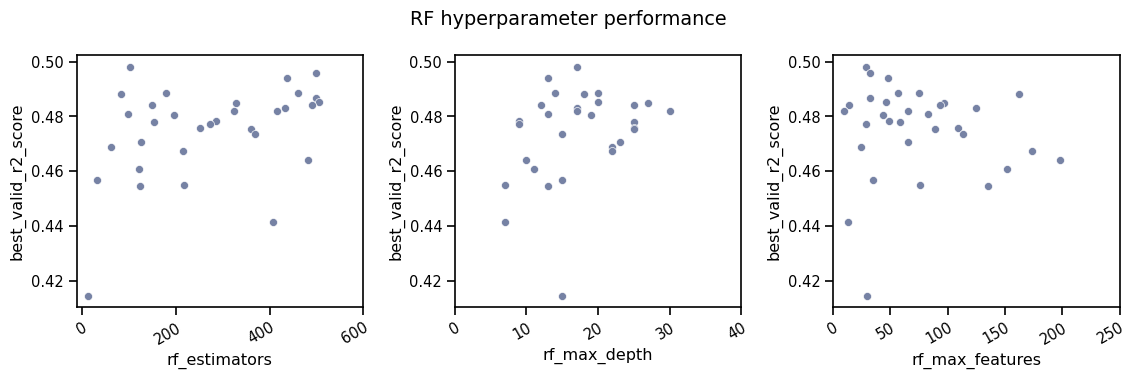

In [11]:
hpp.plot_hyper_perf(result_df, model_type='RF', subset='valid', scoretype='r2_score')

We can quickly get a list of scores to plot with `get_score_types()` and create the same plots with different metrics.

In [12]:
hpp.get_score_types()

Classification metrics:  ['roc_auc_score', 'prc_auc_score', 'precision', 'recall_score', 'npv', 'accuracy_score', 'kappa', 'matthews_cc', 'bal_accuracy']
Regression metrics:  ['r2_score', 'mae_score', 'rms_score']


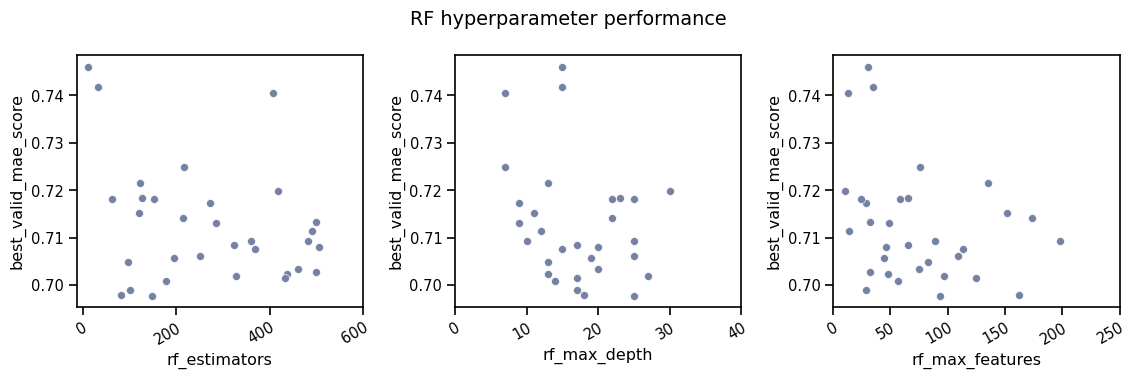

In [13]:
hpp.plot_hyper_perf(result_df, model_type='RF', subset='valid', scoretype='mae_score')

### NN visualization
When visualizing hyperparameters of `NN` models in this case, it is slightly hard to see important trends because there is a large variance in their model performance. To avoid this, we use `plot_hyper_perf()` with a subsetted dataframe to look at a single combination of splitter and features. 

|Plot features||
|---|---|
|`avg_dropout`|The average of dropout proportions across all layers of the model. This parameter can affect the generalizability and overfitting of the model and usually dropout of 0.1 or higher is best.|
|`learning_rate`|The learning rate during training. Generally, learning rates that are ~10e-3 do best.|
|`num_weights`|The product of layer sizes plus number of nodes in first layer, a rough estimate of total model size/complexity. This parameter should be minimized by selecting the smallest layer sizes possible that still maximize the preferred metric|
|`num_layers`|The number of layers in the NN, another marker of complexity. This should also be minimized.|
|`best_epoch`|Which epoch had the highest performance metric during training. This can indicate problematic training if the best_epochs are very small.|
|`max_epochs`|The max number of epochs the model was allowed to train (although early stopping may have occurred). If the max_epochs is too small you may underfit your model. This could be shown by all of your best_epochs being at max_epoch.|

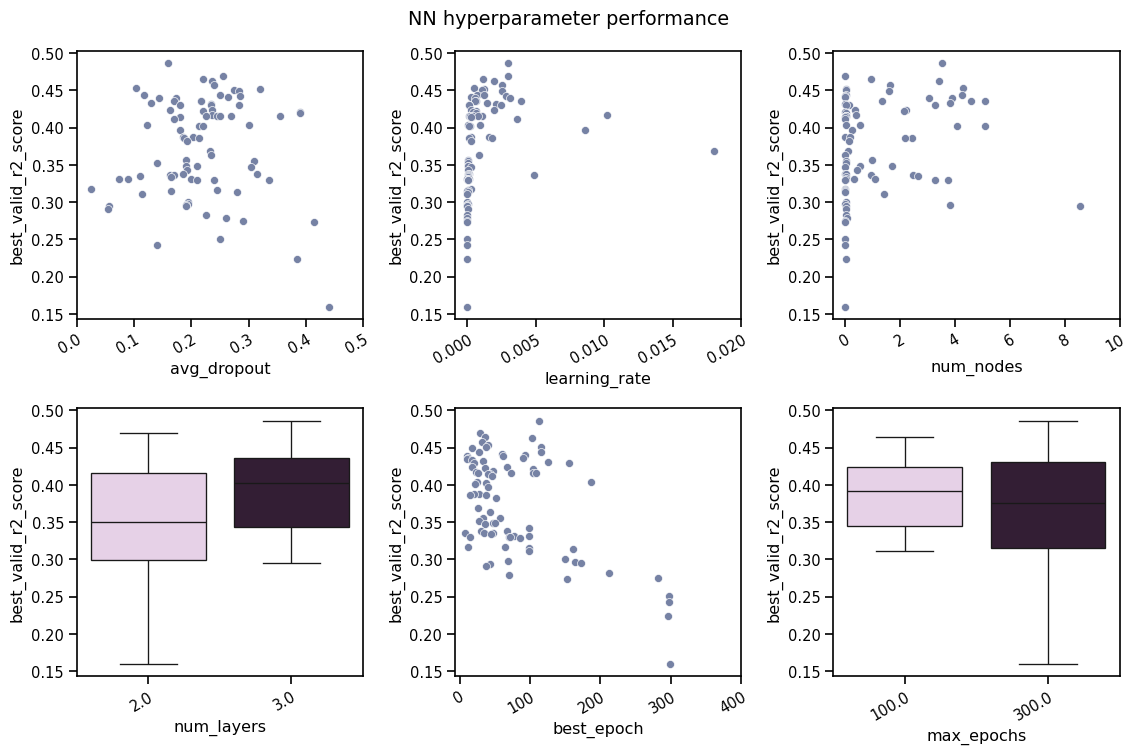

In [14]:
subsetted=result_df[result_df.splitter=='scaffold']
subsetted=subsetted[subsetted.features=='rdkit_raw']

hpp.plot_hyper_perf(subsetted, model_type='NN')

### XGBoost visualization
Using `plot_xg_perf()`, we can simultaneously visualize the two most important parameters for **[XGBoost](https://en.wikipedia.org/wiki/XGBoost)** models - the learning rate and gamma. We can see that `xgb_learning_rate` should be between 0 and 0.45, after which the performance starts to deteriorate. There's no clear trend for `xgb_gamma`. We can additionally use `plot_hyper_perf()` to visualize more **[XGBoost](https://en.wikipedia.org/wiki/XGBoost)** parameters, but this is not shown here.

In [15]:
# hpp.plot_hyper_perf(result_df, model_type='xgboost')

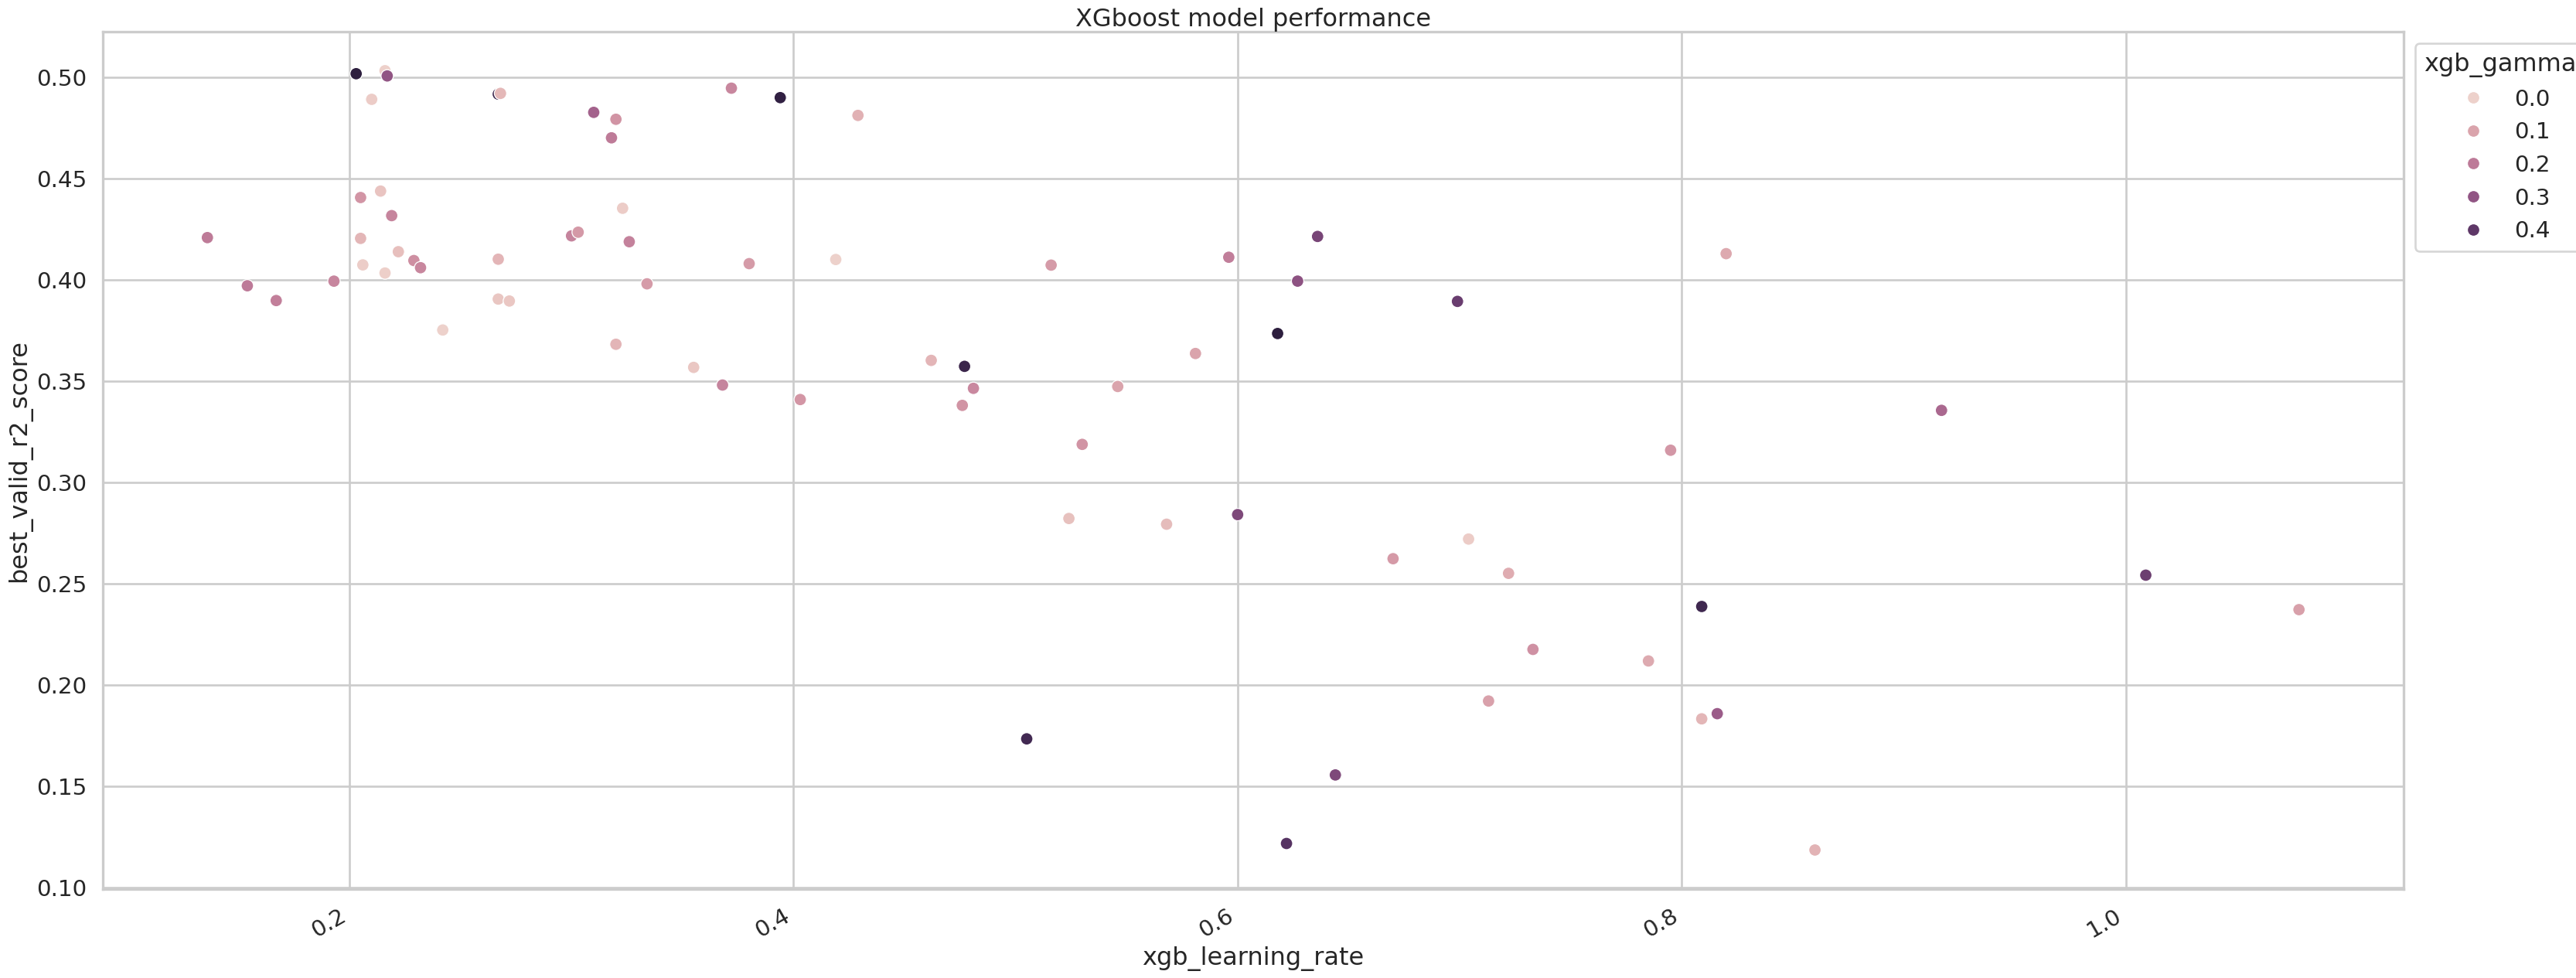

In [15]:
hpp.plot_xg_perf(result_df)

## Evaluation of a single model

After calling `compare_models.get_filesystem_perf_results()`, the dataframe can be sorted according to the score you care about. The column `model_parameters_dict` contains hyperparameters used for the best model. We can visualize this model using `perf_plots.plot_pred_vs_actual_from_file()`.

Note: not all scores should be maximized. For example, `mae_score` or `rms_score` should be minimized instead.

In [16]:
winnertype='best_valid_r2_score'

# result_df=cm.get_filesystem_perf_results(result_dir='dataset/SLC6A3_models/', pred_type='regression')

result_df=pd.read_csv('dataset/SLC6A3_models/07_example_pred_df.csv', index_col=0)
result_df=result_df.sort_values(winnertype, ascending=False)

We can examine important parameters of the top model directly from the `result_df`. 

We see that through hyperparameter optimization, we have increased our `best_valid_r2_score` to 0.56, as compared to our baseline model `valid_r2_score` of 0.50011 (from **tutorial 4, "Train a Simple Regression Model"**).

In [17]:
result_df.iloc[0][['features','splitter','best_valid_r2_score']]

features                   ecfp
splitter               scaffold
best_valid_r2_score    0.562091
Name: 310, dtype: object

In [18]:
result_df.iloc[0].model_parameters_dict

'{"best_epoch": 24, "dropouts": [0.27866421599874197, 0.3041982566364109, 0.29943876674824], "layer_sizes": [369, 283, 146], "learning_rate": 8.28816038984145e-05, "max_epochs": 100}'

In [19]:
result_df.iloc[0].model_path

'dataset/SLC6A3_models/SLC6A3_Ki_curated_model_b24a2887-8eca-43e2-8fc2-3642189d2c94.tar.gz'

Here we use `plot_pred_vs_actual_from_file()` to visualize the prediction accuracy for the train, validation and test sets.
> **Note:** *For the purposes of this tutorial, the following models have been altered to work on every file system. In general, this function is meant for quick analysis of models you've trained on your own machine. To use an external model and predict on external data, see **tutorial 5, "Application of a Trained Model"**.*

2024-05-23 10:07:00,542 dataset/SLC6A3_models/SLC6A3_Ki_curated_model_b24a2887-8eca-43e2-8fc2-3642189d2c94.tar.gz, 1.6.0
2024-05-23 10:07:00,545 Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_b24a2887-8eca-43e2-8fc2-3642189d2c94.tar.gz version = "1.6", AMPL version = "1.6"


['/var/folders/rf/_d6b2mgd3p9f422kk977zjlh0000gn/T/tmpz6urng5n/best_model/checkpoint1.pt']
/var/folders/rf/_d6b2mgd3p9f422kk977zjlh0000gn/T/tmpz6urng5n/best_model/checkpoint1.pt


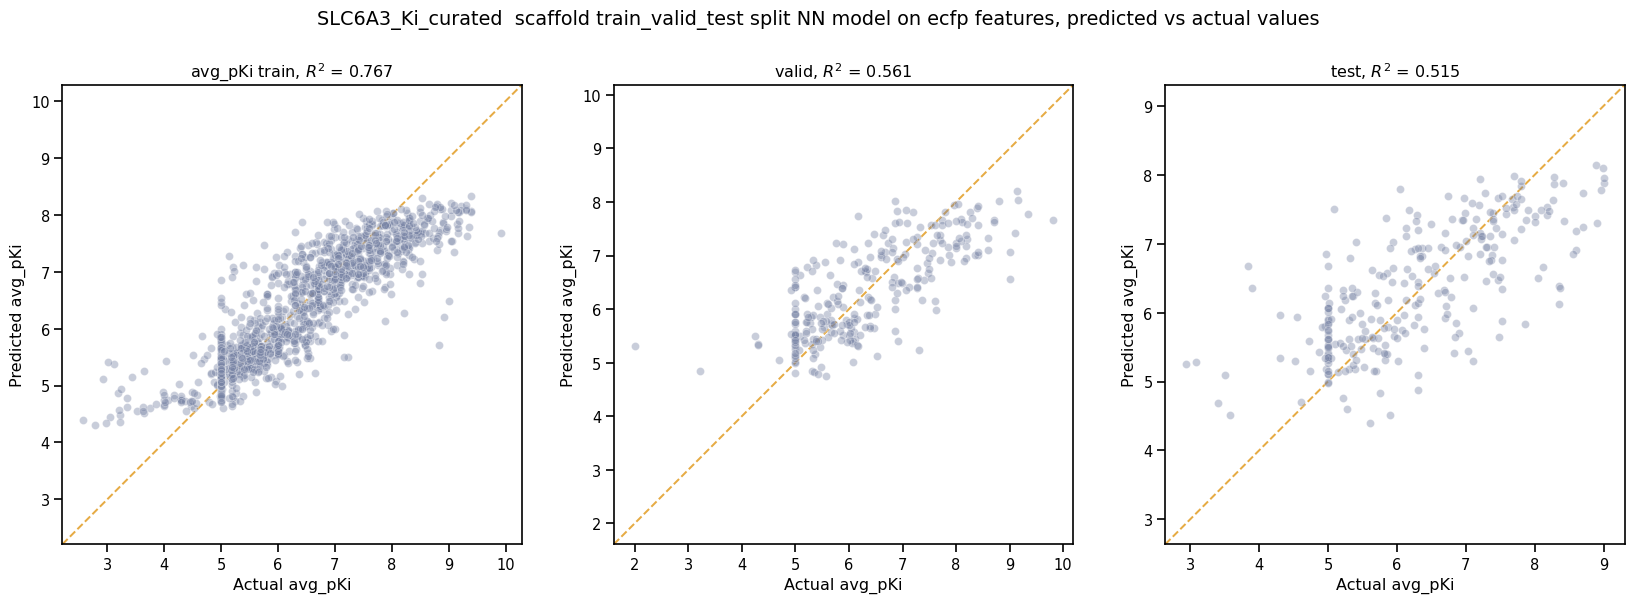

In [20]:
# plot best model, an NN
import importlib
importlib.reload(pp)
model_path=result_df.iloc[0].model_path
pp.plot_pred_vs_actual_from_file(model_path)

This `NN` model looks like it isn't very good at predicting things with $pKi$ < 4.5. Additionally, there is a set of data at $pKi$=5 (this data is censored and all we know is that the compounds have a $pKi$ < 5 because higher concentrations of drug were not tested). This data is poorly predicted by the NN model.
> **Note:** *Be wary of selecting models only based on their performance metrics! As we can see, this NN has problems even though the r2_score is fairly high.*

2024-05-23 10:07:13,015 dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz, 1.6.0
2024-05-23 10:07:13,018 Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz version = "1.6", AMPL version = "1.6"



Best valid r2 score:  0.5595899501867392

Model Parameters:  {"rf_estimators": 129, "rf_max_depth": 32, "rf_max_features": 95} 



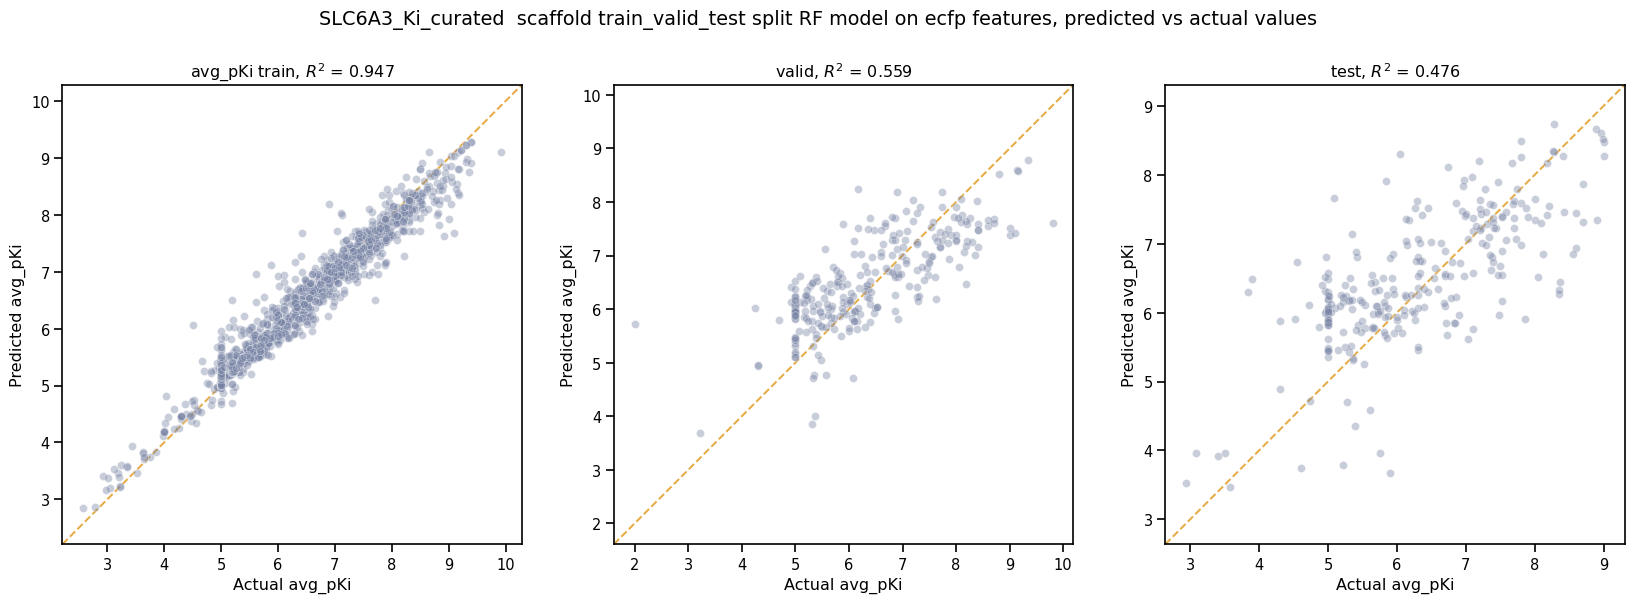

In [21]:
# plot best RF model
model_type='RF'
model_path=result_df[result_df.model_type==model_type].iloc[0].model_path
pp.plot_pred_vs_actual_from_file(model_path)
print('\nBest valid r2 score: ',result_df[result_df.model_type==model_type].iloc[0].best_valid_r2_score)
print('\nModel Parameters: ',result_df[result_df.model_type==model_type].iloc[0].model_parameters_dict,'\n')

This `RF` model looks like it did better at training than the best `NN` model, even though its performance validation score is slightly lower. The low $pKi$ values are learned more accurately in the training set, and the censored data at $pKi$=5 is also predicted more accurately.

2024-05-23 10:07:25,456 dataset/SLC6A3_models/SLC6A3_Ki_curated_model_94458d7b-7f94-44c9-83c3-a35833e76c37.tar.gz, 1.6.0
2024-05-23 10:07:25,459 Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_94458d7b-7f94-44c9-83c3-a35833e76c37.tar.gz version = "1.6", AMPL version = "1.6"
/opt/anaconda3/envs/atomsci-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:07:25] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)



Best valid r2 score:  0.5031490908520113

Model Parameters:  {"xgb_colsample_bytree": 1.0, "xgb_gamma": 0.0019288871251215423, "xgb_learning_rate": 0.2158168689218416, "xgb_max_depth": 6, "xgb_min_child_weight": 1.0, "xgb_n_estimators": 100, "xgb_subsample": 1.0} 



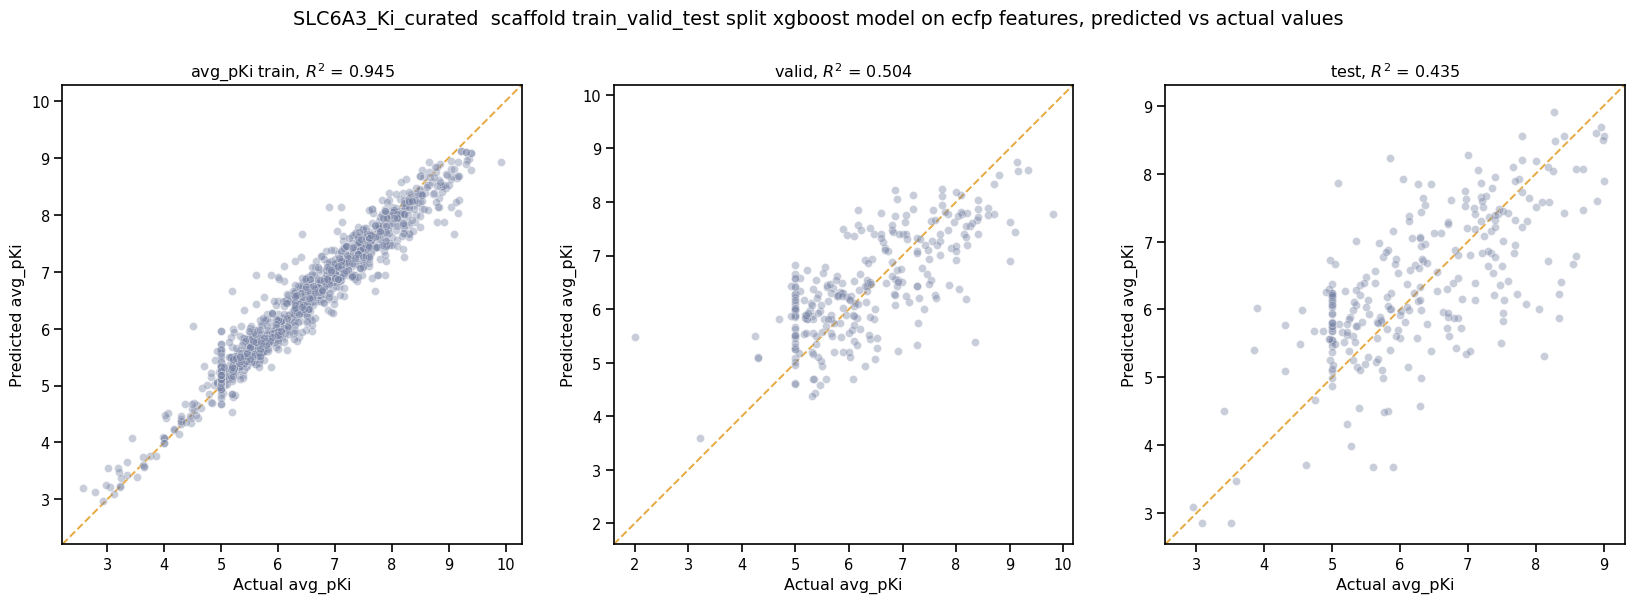

In [22]:
# plot best xgboost model
model_type='xgboost'
model_path=result_df[result_df.model_type==model_type].iloc[0].model_path
pp.plot_pred_vs_actual_from_file(model_path)
print('\nBest valid r2 score: ',result_df[result_df.model_type==model_type].iloc[0].best_valid_r2_score)
print('\nModel Parameters: ',result_df[result_df.model_type==model_type].iloc[0].model_parameters_dict,'\n')

This **[XGBoost](https://en.wikipedia.org/wiki/XGBoost)** model learns the low $pKi$ values better but still suffers from problems with predicting the censored data. 

Moving forward, we would select the `RF` model as the best performer.

In **tutorial 8, "Train a Production Model"**, we will use the best-performing parameters to create a production model for the entire dataset.